In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

Using TensorFlow backend.


# Load images and labels

In [3]:
num_classes = 10

(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()
print('orginal training images shape: {}\norginal training labels shape: {}\n'.format(x_train_org.shape, y_train_org.shape))
print('testing images shape: {}\ntesting labels shape: {}'.format(x_test_org.shape, y_test_org.shape))

orginal training images shape: (60000, 28, 28)
orginal training labels shape: (60000,)

testing images shape: (10000, 28, 28)
testing labels shape: (10000,)


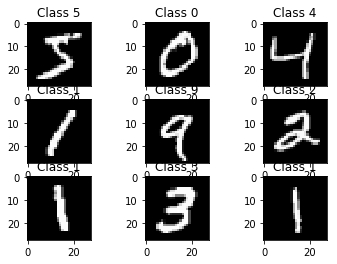

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train_org[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train_org[i]))

In [5]:
x_train_org = np.expand_dims(x_train_org, axis=-1) / 255.
x_test_org = np.expand_dims(x_test_org, axis=-1) / 255.

x_train = x_train_org[:50000]
y_train = to_categorical(y_train_org[:50000], num_classes)
x_valid = x_train_org[50000:]
y_valid = to_categorical(y_train_org[50000:], num_classes)

x_test = x_test_org
y_test = to_categorical(y_test_org)

print('x_train shape: {} // y_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_valid shape: {} // y_valid.shape: {}'.format(x_valid.shape, y_valid.shape))

x_train shape: (50000, 28, 28, 1) // y_train.shape: (50000, 10)
x_valid shape: (10000, 28, 28, 1) // y_valid.shape: (10000, 10)


# Construct model architecture

In [6]:
def myCNN():
    img_input = Input(shape=(28, 28, 1))
    co1 = Conv2D(10, (5, 5), padding='valid', activation='relu', name='co1')(img_input)
    do1 = Dropout(0.2, name='do1')(co1)
    co2 = Conv2D(10, (5, 5), padding='valid', activation='relu', name='co2')(do1)
    do2 = Dropout(0.2, name='do2')(co2)
    flat = Flatten()(do2)
    fc1 = Dense(num_classes, activation='softmax', name='do3')(flat)

    model = Model(img_input, fc1)
    L_model = Model(img_input, co1)
    H_model = Model(img_input, do2)
    
    return model, L_model, H_model

In [7]:
model, L_model, H_model = myCNN()
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

ckpt = ModelCheckpoint('CNN_model_e{epoch:02d}', # CNN_model_e{epoch:02d}_a{val_acc:.4f}
                       monitor='val_acc',
                       save_best_only=False,
                       save_weights_only=True,
                       verbose=1)
cb = [ckpt]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
co1 (Conv2D)                 (None, 24, 24, 10)        260       
_________________________________________________________________
do1 (Dropout)                (None, 24, 24, 10)        0         
_________________________________________________________________
co2 (Conv2D)                 (None, 20, 20, 10)        2510      
_________________________________________________________________
do2 (Dropout)                (None, 20, 20, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
do3 (Dense)                  (None, 10)                40010     
Total para

# Start to train CNN model

In [8]:
epochs = 20
batch_size = 256

history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks=cb,
                    verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 41s 815us/step - loss: 1.1859 - acc: 0.6690 - val_loss: 0.4154 - val_acc: 0.8830

Epoch 00001: saving model to CNN_model_e01
Epoch 2/20
50000/50000 [==============================] - 41s 820us/step - loss: 0.4303 - acc: 0.8714 - val_loss: 0.3010 - val_acc: 0.9154

Epoch 00002: saving model to CNN_model_e02
Epoch 3/20
50000/50000 [==============================] - 41s 828us/step - loss: 0.3396 - acc: 0.8987 - val_loss: 0.2507 - val_acc: 0.9307

Epoch 00003: saving model to CNN_model_e03
Epoch 4/20
50000/50000 [==============================] - 43s 864us/step - loss: 0.2842 - acc: 0.9158 - val_loss: 0.2129 - val_acc: 0.9407

Epoch 00004: saving model to CNN_model_e04
Epoch 5/20
50000/50000 [==============================] - 45s 907us/step - loss: 0.2436 - acc: 0.9288 - val_loss: 0.1854 - val_acc: 0.9487

Epoch 00005: saving model to CNN_model_e05
Epoch 6/20
50000/50000 [===========

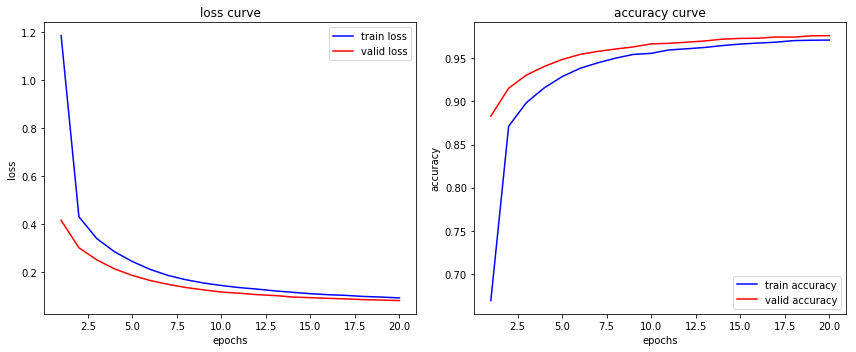

In [9]:
l = history.history['loss']
vl = history.history['val_loss']
acc = history.history['acc']
vacc = history.history['val_acc']

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.arange(epochs)+1, l, 'b', label='train loss')
plt.plot(np.arange(epochs)+1, vl, 'r', label='valid loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss curve")
plt.legend(loc='best')

plt.subplot(122)
plt.plot(np.arange(epochs)+1, acc, 'b', label='train accuracy')
plt.plot(np.arange(epochs)+1, vacc, 'r', label='valid accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy curve")
plt.legend(loc='best')
plt.tight_layout()

plt.show()

# Evaluate model on the test dataset

In [10]:
model_name = 'CNN_model_e20'
model.load_weights(model_name)

# prediction = model.predict(x_test)
accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Testing accuracy: {}'.format(accuracy))

Testing accuracy: [0.0704437150507234, 0.9795]
